In [ ]:
# coding:utf-8  
'''
@author: Jason.F
@data: 2019.08.12
@function: BMF(Bayesian Matrix Factorization) 
           Datatset: MovieLens-1m:https://grouplens.org/datasets/movielens/  
           Evaluation: RMSE
'''
import sys
import time
import logging
import random
import heapq
import math
from collections import defaultdict
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import tensorflow as tf

class DataSet:
    def __init__(self):
        self.trainset, self.testset, self.maxu, self.maxi, self.maxr = self._getDataset_as_list()
        
    def _getDataset_as_list(self):
        #trainset
        filePath = "/data/fjsdata/BMF/ml-1m.train.rating" 
        data = pd.read_csv(filePath, sep='\t', header=None, names=['user', 'item', 'rating'], \
                                 usecols=[0, 1, 2], dtype={0: np.int32, 1: np.int32, 2: np.float})
        maxu, maxi, maxr = data['user'].max()+1, data['item'].max()+1, data['rating'].max()
        print('Dataset Statistics: Interaction = %d, User = %d, Item = %d, Sparsity = %.4f' % \
                  (data.shape[0], maxu, maxi, data.shape[0]/(maxu*maxi)))
        trainset = data.values.tolist()
        #testset
        filePath = "/data/fjsdata/BMF/ml-1m.test.rating" 
        data = pd.read_csv(filePath, sep='\t', header=None, names=['user', 'item', 'rating'], \
                                 usecols=[0, 1, 2], dtype={0: np.int32, 1: np.int32, 2: np.float})
        testset = data.values.tolist()
        return trainset, testset, maxu, maxi, maxr 
    
    def list_to_matrix(self, dataset, maxu, maxi):              
        dataMat = np.zeros([maxu, maxi], dtype=np.float32)
        for u,i,r in dataset:
            dataMat[int(u)][int(i)] = float(r)
        return np.array(dataMat)
    
    def list_to_dict(self, dataset):
        dataDict = {}
        for u,i,r in dataset:
            dataDict[int(u), int(i)] = float(r)
        return dataDict
    
    def getInstances(self, dataset):
        user = []
        item = []
        rate = []
        for u, i, r in dataset:
            user.append(int(u))
            item.append(int(i))
            rate.append(float(r))
        return np.array(user), np.array(item), np.array(rate)
    
class BMF():
    def __init__(self, ds):
        self.maxr = ds.maxr
        self.maxu = ds.maxu
        self.maxi = ds.maxi
        #get the trainset and testset
        train_u, train_i, train_r = ds.getInstances(ds.trainset)
        shuffled_idx = np.random.permutation(np.arange(len(train_u)))
        self.train_u = train_u[shuffled_idx]
        self.train_i = train_i[shuffled_idx]
        self.train_r = train_r[shuffled_idx]
        assert(len(self.train_u) == len(self.train_i) and len(self.train_i) == len(self.train_r)) 
        self.test_u, self.test_i, self.test_r = ds.getInstances(ds.testset)
        assert(len(self.test_u) == len(self.test_i) and len(self.test_i) == len(self.test_r))
    
    def train_BMF(self, K=8,spl=100):
        meanr = self.maxr/2
        self.x_u = theano.shared(self.train_u)
        self.x_i = theano.shared(self.train_i)
        self.y_r = theano.shared(self.train_r)
        with pm.Model() as self.bmf:#bulid probabilistic model
            # Creating the model
            P = pm.Normal('P', mu=0, sd=meanr, shape=(self.maxu, K))
            Q = pm.Normal('Q', mu=0, sd=meanr, shape=(self.maxi, K))
            tY = pm.Deterministic('tY', pm.math.sum(P[self.x_u,:]*Q[self.x_i,:], axis=1))
            Y = pm.Normal('Y', mu=tY, sd=meanr, observed=self.y_r)#pm.Categorical
            
        with self.bmf: #train the probabilistic model by Bayesian inference
            tstart = time.time()
            print('Start training BMF')
            approx = pm.fit(n=10000, method=pm.ADVI())
            trace = approx.sample(draws=spl)
            elapsed = time.time() - tstart 
            print('Complete BMF training in %d seconds' % int(elapsed))
        return trace
            
    def eval_BMF(self, trace):
        self.x_u.set_value(self.test_u)
        self.x_i.set_value(self.test_i)
        self.y_r.set_value(self.test_r)
        with self.bmf:
            ppc = pm.sample_posterior_predictive(trace, progressbar=True)
            pY = ppc['Y'].mean(axis=0)
            #pY = np.max(ppc['Y'],axis=0)
        assert(pY.shape[0]==self.test_r.shape[0])
        squaredError = []
        for i in range(pY.shape[0]):
            error=self.test_r[i] - pY[i]
            squaredError.append(error * error)
        rmse =math.sqrt(sum(squaredError) / len(squaredError))
        return rmse
    
    def eval_val(self, trace, val_u, val_i, val_r):
        self.x_u.set_value(val_u)
        self.x_i.set_value(val_i)
        self.y_r.set_value(val_r)
        with self.bmf:
            ppc = pm.sample_posterior_predictive(trace, progressbar=True)
            pY = ppc['Y'].mean(axis=0)
            #pY = np.max(ppc['Y'],axis=0)
        assert(pY.shape[0]==val_r.shape[0])
        squaredError = []
        for i in range(pY.shape[0]):
            error=val_r[i] - pY[i]
            squaredError.append(error * error)
        rmse =math.sqrt(sum(squaredError) / len(squaredError))
        return rmse
    
if __name__ == "__main__":
    ds = DataSet()#loading dataset
    bmf = BMF(ds)
    for K in [8, 16, 32, 64]:
        for spl in [100,200,300,400,500,600,700,800,900,1000]:
            trace = bmf.train_BMF(K=K, spl=spl)
            rmse = bmf.eval_BMF(trace)
            print("RMSE@{}@{}:{}".format(K,spl,rmse))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Dataset Statistics: Interaction = 994169, User = 6040, Item = 3706, Sparsity = 0.0444
Start training BMF


Average Loss = 2.0634e+06: 100%|██████████| 10000/10000 [50:16<00:00,  3.55it/s]
Finished [100%]: Average Loss = 2.0634e+06
I0817 01:44:22.988378 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.0634e+06
  6%|▌         | 6/100 [00:00<00:01, 58.32it/s]

Complete BMF training in 3031 seconds


100%|██████████| 100/100 [00:01<00:00, 82.46it/s]


RMSE@8@100:1.021273603460722
Start training BMF


Average Loss = 2.0635e+06: 100%|██████████| 10000/10000 [50:52<00:00,  2.95it/s]
Finished [100%]: Average Loss = 2.0634e+06
I0817 02:35:27.243470 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.0634e+06
  2%|▏         | 3/200 [00:00<00:06, 28.28it/s]

Complete BMF training in 3070 seconds


100%|██████████| 200/200 [00:02<00:00, 84.24it/s]


RMSE@8@200:1.0012466785692231
Start training BMF


Average Loss = 2.0628e+06: 100%|██████████| 10000/10000 [51:50<00:00,  3.40it/s] 
Finished [100%]: Average Loss = 2.0628e+06
I0817 03:27:38.473165 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.0628e+06
  3%|▎         | 10/300 [00:00<00:03, 95.82it/s]

Complete BMF training in 3136 seconds


100%|██████████| 300/300 [00:04<00:00, 70.06it/s]


RMSE@8@300:0.9972911041752818
Start training BMF


Average Loss = 2.0634e+06: 100%|██████████| 10000/10000 [51:17<00:00,  3.42it/s]
Finished [100%]: Average Loss = 2.0633e+06
I0817 04:19:26.891957 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.0633e+06
  3%|▎         | 11/400 [00:00<00:03, 102.64it/s]

Complete BMF training in 3112 seconds


100%|██████████| 400/400 [00:04<00:00, 96.26it/s] 


RMSE@8@400:0.9891143925433187
Start training BMF


Average Loss = 2.0635e+06: 100%|██████████| 10000/10000 [48:07<00:00,  3.77it/s]
Finished [100%]: Average Loss = 2.0634e+06
I0817 05:08:14.583849 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.0634e+06
  2%|▏         | 10/500 [00:00<00:05, 94.67it/s]

Complete BMF training in 2928 seconds


100%|██████████| 500/500 [00:04<00:00, 101.86it/s]


RMSE@8@500:0.9916012144565016
Start training BMF


Average Loss = 2.0636e+06: 100%|██████████| 10000/10000 [47:32<00:00,  3.62it/s]
Finished [100%]: Average Loss = 2.0635e+06
I0817 05:56:32.280999 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.0635e+06
  2%|▏         | 10/600 [00:00<00:06, 97.60it/s]

Complete BMF training in 2899 seconds


100%|██████████| 600/600 [00:06<00:00, 84.17it/s] 


RMSE@8@600:0.9898304561064037
Start training BMF


Average Loss = 2.0635e+06: 100%|██████████| 10000/10000 [46:32<00:00,  3.71it/s]
Finished [100%]: Average Loss = 2.0635e+06
I0817 06:43:59.244182 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.0635e+06
  1%|          | 5/700 [00:00<00:14, 46.86it/s]

Complete BMF training in 2848 seconds


100%|██████████| 700/700 [00:07<00:00, 99.77it/s] 


RMSE@8@700:0.9894984379046142
Start training BMF


Average Loss = 2.0636e+06: 100%|██████████| 10000/10000 [46:39<00:00,  3.76it/s]
Finished [100%]: Average Loss = 2.0636e+06
I0817 07:31:41.734160 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.0636e+06
  1%|▏         | 10/800 [00:00<00:08, 93.25it/s]

Complete BMF training in 2863 seconds


100%|██████████| 800/800 [00:07<00:00, 105.50it/s]


RMSE@8@800:0.9869122502195924
Start training BMF


Average Loss = 2.0636e+06: 100%|██████████| 10000/10000 [47:03<00:00,  3.59it/s]
Finished [100%]: Average Loss = 2.0635e+06
I0817 08:19:57.502694 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.0635e+06
  1%|          | 10/900 [00:00<00:09, 96.83it/s]

Complete BMF training in 2896 seconds


100%|██████████| 900/900 [00:08<00:00, 103.16it/s]


RMSE@8@900:0.9891403687443295
Start training BMF


Average Loss = 2.0628e+06: 100%|██████████| 10000/10000 [47:48<00:00,  3.03it/s]
Finished [100%]: Average Loss = 2.0627e+06
I0817 09:09:07.236330 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.0627e+06
  1%|          | 10/1000 [00:00<00:10, 96.70it/s]

Complete BMF training in 2948 seconds


100%|██████████| 1000/1000 [00:09<00:00, 104.37it/s]


RMSE@8@1000:0.9860753934527827
Start training BMF


Average Loss = 2.1693e+06: 100%|██████████| 10000/10000 [1:22:48<00:00,  1.78it/s]
Finished [100%]: Average Loss = 2.1692e+06
I0817 10:33:25.618396 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.1692e+06
 10%|█         | 10/100 [00:00<00:00, 97.75it/s]

Complete BMF training in 4983 seconds


100%|██████████| 100/100 [00:00<00:00, 108.81it/s]


RMSE@16@100:1.0319372993339944
Start training BMF


Average Loss = 2.1688e+06: 100%|██████████| 10000/10000 [1:23:05<00:00,  2.02it/s]
Finished [100%]: Average Loss = 2.1687e+06
I0817 11:56:48.345996 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.1687e+06
  2%|▎         | 5/200 [00:00<00:04, 47.08it/s]

Complete BMF training in 5016 seconds


100%|██████████| 200/200 [00:01<00:00, 101.69it/s]


RMSE@16@200:1.0071320309113612
Start training BMF


Average Loss = 2.1682e+06: 100%|██████████| 10000/10000 [1:21:07<00:00,  2.18it/s]
Finished [100%]: Average Loss = 2.1681e+06
I0817 13:18:29.064897 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.1681e+06
  2%|▏         | 5/300 [00:00<00:06, 43.38it/s]

Complete BMF training in 4911 seconds


100%|██████████| 300/300 [00:03<00:00, 99.59it/s] 


RMSE@16@300:0.9973886142037969
Start training BMF


Average Loss = 2.1686e+06: 100%|██████████| 10000/10000 [1:22:19<00:00,  2.02it/s]
Finished [100%]: Average Loss = 2.1686e+06
I0817 14:41:36.256348 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.1686e+06
  1%|          | 4/400 [00:00<00:10, 37.82it/s]

Complete BMF training in 4997 seconds


100%|██████████| 400/400 [00:04<00:00, 67.08it/s] 


RMSE@16@400:0.9974876103781327
Start training BMF


Average Loss = 2.1679e+06: 100%|██████████| 10000/10000 [1:21:18<00:00,  2.10it/s]
Finished [100%]: Average Loss = 2.1679e+06
I0817 16:03:57.477399 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.1679e+06
  2%|▏         | 9/500 [00:00<00:05, 87.81it/s]

Complete BMF training in 4951 seconds


100%|██████████| 500/500 [00:04<00:00, 112.10it/s]


RMSE@16@500:0.9934571741959195
Start training BMF


Average Loss = 2.1688e+06: 100%|██████████| 10000/10000 [1:21:06<00:00,  1.83it/s]
Finished [100%]: Average Loss = 2.1687e+06
I0817 17:26:22.924585 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.1687e+06
  1%|          | 5/600 [00:00<00:13, 45.30it/s]

Complete BMF training in 4955 seconds


100%|██████████| 600/600 [00:06<00:00, 97.45it/s] 


RMSE@16@600:0.9952034533727055
Start training BMF


Average Loss = 2.1698e+06: 100%|██████████| 10000/10000 [1:21:19<00:00,  2.10it/s]
Finished [100%]: Average Loss = 2.1697e+06
I0817 18:49:17.040463 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.1697e+06
  1%|          | 5/700 [00:00<00:15, 44.12it/s]

Complete BMF training in 4981 seconds


100%|██████████| 700/700 [00:07<00:00, 98.64it/s] 


RMSE@16@700:0.9942324453686942
Start training BMF


Average Loss = 2.1694e+06: 100%|██████████| 10000/10000 [1:20:55<00:00,  2.18it/s]
Finished [100%]: Average Loss = 2.1694e+06
I0817 20:12:03.072837 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.1694e+06
  1%|▏         | 10/800 [00:00<00:08, 98.10it/s]

Complete BMF training in 4971 seconds


100%|██████████| 800/800 [00:07<00:00, 106.62it/s]


RMSE@16@800:0.9912533527864686
Start training BMF


Average Loss = 2.1687e+06: 100%|██████████| 10000/10000 [1:22:10<00:00,  2.05it/s]
Finished [100%]: Average Loss = 2.1687e+06
I0817 21:36:18.389569 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.1687e+06
  1%|          | 9/900 [00:00<00:10, 88.74it/s]

Complete BMF training in 5065 seconds


100%|██████████| 900/900 [00:08<00:00, 100.58it/s]


RMSE@16@900:0.9911334924715296
Start training BMF


Average Loss = 2.1696e+06: 100%|██████████| 10000/10000 [1:21:58<00:00,  2.00it/s]
Finished [100%]: Average Loss = 2.1695e+06
I0817 23:00:40.862898 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.1695e+06
  1%|          | 9/1000 [00:00<00:11, 88.65it/s]

Complete BMF training in 5065 seconds


100%|██████████| 1000/1000 [00:09<00:00, 103.88it/s]


RMSE@16@1000:0.9921441301332106
Start training BMF


Average Loss = 2.3618e+06: 100%|██████████| 10000/10000 [2:36:39<00:00,  1.01s/it] 
Finished [100%]: Average Loss = 2.3618e+06
I0818 01:39:57.492990 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.3618e+06
  6%|▌         | 6/100 [00:00<00:01, 59.57it/s]

Complete BMF training in 9428 seconds


100%|██████████| 100/100 [00:00<00:00, 102.38it/s]


RMSE@32@100:1.0349945263400566
Start training BMF


Average Loss = 2.3596e+06: 100%|██████████| 10000/10000 [2:34:57<00:00,  1.10it/s] 
Finished [100%]: Average Loss = 2.3595e+06
I0818 04:15:25.911129 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.3595e+06
  2%|▎         | 5/200 [00:00<00:04, 45.07it/s]

Complete BMF training in 9355 seconds


100%|██████████| 200/200 [00:02<00:00, 77.22it/s] 


RMSE@32@200:1.0180548211315923
Start training BMF


Average Loss = 2.3614e+06: 100%|██████████| 10000/10000 [2:35:31<00:00,  1.02s/it] 
Finished [100%]: Average Loss = 2.3613e+06
I0818 06:51:59.456402 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.3613e+06
  3%|▎         | 10/300 [00:00<00:03, 93.72it/s]

Complete BMF training in 9416 seconds


100%|██████████| 300/300 [00:02<00:00, 107.57it/s]


RMSE@32@300:1.0043393268307608
Start training BMF


Average Loss = 2.3616e+06: 100%|██████████| 10000/10000 [2:35:32<00:00,  1.13it/s] 
Finished [100%]: Average Loss = 2.3615e+06
I0818 09:29:00.786782 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.3615e+06
  1%|          | 4/400 [00:00<00:10, 37.02it/s]

Complete BMF training in 9448 seconds


100%|██████████| 400/400 [00:04<00:00, 85.60it/s] 


RMSE@32@400:1.0042208123529943
Start training BMF


Average Loss = 2.3607e+06: 100%|██████████| 10000/10000 [2:36:09<00:00,  1.08it/s] 
Finished [100%]: Average Loss = 2.3607e+06
I0818 12:07:12.439926 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.3607e+06
  2%|▏         | 9/500 [00:00<00:05, 87.84it/s]

Complete BMF training in 9511 seconds


100%|██████████| 500/500 [00:04<00:00, 102.79it/s]


RMSE@32@500:0.9999447612635265
Start training BMF


Average Loss = 2.3628e+06: 100%|██████████| 10000/10000 [2:44:54<00:00,  1.06it/s] 
Finished [100%]: Average Loss = 2.3627e+06
I0818 14:54:34.155707 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.3627e+06
  0%|          | 3/600 [00:00<00:20, 28.83it/s]

Complete BMF training in 10074 seconds


100%|██████████| 600/600 [00:06<00:00, 87.38it/s] 


RMSE@32@600:0.9985937340837074
Start training BMF


Average Loss = 2.3626e+06: 100%|██████████| 10000/10000 [2:43:38<00:00,  1.12it/s] 
Finished [100%]: Average Loss = 2.3625e+06
I0818 17:41:19.612937 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.3625e+06
  1%|▏         | 10/700 [00:00<00:07, 91.63it/s]

Complete BMF training in 10027 seconds


100%|██████████| 700/700 [00:07<00:00, 93.56it/s] 


RMSE@32@700:0.9990785447427386
Start training BMF


Average Loss = 2.3587e+06: 100%|██████████| 10000/10000 [2:43:21<00:00,  1.05it/s] 
Finished [100%]: Average Loss = 2.3586e+06
I0818 20:28:19.381066 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.3586e+06
  1%|          | 8/800 [00:00<00:10, 74.77it/s]

Complete BMF training in 10039 seconds


100%|██████████| 800/800 [00:08<00:00, 99.21it/s] 


RMSE@32@800:0.9985247519351772
Start training BMF


Average Loss = 2.3622e+06: 100%|██████████| 10000/10000 [2:44:18<00:00,  1.01it/s] 
Finished [100%]: Average Loss = 2.3621e+06
I0818 23:16:44.388461 139895818053376 inference.py:248] Finished [100%]: Average Loss = 2.3621e+06
  0%|          | 4/900 [00:00<00:22, 39.04it/s]

Complete BMF training in 10130 seconds


100%|██████████| 900/900 [00:09<00:00, 91.65it/s] 


RMSE@32@900:0.9971191508638286
Start training BMF


Average Loss = 3.6772e+06:  10%|▉         | 958/10000 [15:37<2:16:35,  1.10it/s]

In [ ]:
# coding:utf-8  
'''
@author: Jason.F
@data: 2019.08.12
@function: BMF(Bayesian Matrix Factorization) 
           Datatset: MovieLens-1m:https://grouplens.org/datasets/movielens/  
           Evaluation: RMSE
'''
import sys
import time
import logging
import random
import heapq
import math
from collections import defaultdict
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import tensorflow as tf

class DataSet:
    def __init__(self):
        self.trainset, self.testset, self.maxu, self.maxi, self.maxr = self._getDataset_as_list()
        
    def _getDataset_as_list(self):
        #trainset
        filePath = "/data/fjsdata/BMF/ml-1m.train.rating" 
        data = pd.read_csv(filePath, sep='\t', header=None, names=['user', 'item', 'rating'], \
                                 usecols=[0, 1, 2], dtype={0: np.int32, 1: np.int32, 2: np.float})
        maxu, maxi, maxr = data['user'].max()+1, data['item'].max()+1, data['rating'].max()
        print('Dataset Statistics: Interaction = %d, User = %d, Item = %d, Sparsity = %.4f' % \
                  (data.shape[0], maxu, maxi, data.shape[0]/(maxu*maxi)))
        trainset = data.values.tolist()
        #testset
        filePath = "/data/fjsdata/BMF/ml-1m.test.rating" 
        data = pd.read_csv(filePath, sep='\t', header=None, names=['user', 'item', 'rating'], \
                                 usecols=[0, 1, 2], dtype={0: np.int32, 1: np.int32, 2: np.float})
        testset = data.values.tolist()
        return trainset, testset, maxu, maxi, maxr 
    
    def list_to_matrix(self, dataset, maxu, maxi):              
        dataMat = np.zeros([maxu, maxi], dtype=np.float32)
        for u,i,r in dataset:
            dataMat[int(u)][int(i)] = float(r)
        return np.array(dataMat)
    
    def list_to_dict(self, dataset):
        dataDict = {}
        for u,i,r in dataset:
            dataDict[int(u), int(i)] = float(r)
        return dataDict
    
    def getInstances(self, dataset):
        user = []
        item = []
        rate = []
        for u, i, r in dataset:
            user.append(int(u))
            item.append(int(i))
            rate.append(float(r))
        return np.array(user), np.array(item), np.array(rate)
    
class BMF():
    def __init__(self, ds):
        self.maxr = ds.maxr
        self.maxu = ds.maxu
        self.maxi = ds.maxi
        #get the trainset and testset
        train_u, train_i, train_r = ds.getInstances(ds.trainset)
        shuffled_idx = np.random.permutation(np.arange(len(train_u)))
        self.train_u = train_u[shuffled_idx]
        self.train_i = train_i[shuffled_idx]
        self.train_r = train_r[shuffled_idx]
        assert(len(self.train_u) == len(self.train_i) and len(self.train_i) == len(self.train_r)) 
        self.test_u, self.test_i, self.test_r = ds.getInstances(ds.testset)
        assert(len(self.test_u) == len(self.test_i) and len(self.test_i) == len(self.test_r))
    
    def train_BMF(self, K=8, step=5000, spl=500):
        meanr = self.maxr/2
        self.x_u = theano.shared(self.train_u)
        self.x_i = theano.shared(self.train_i)
        self.y_r = theano.shared(self.train_r)
        with pm.Model() as self.bmf:#bulid probabilistic model
            # Creating the model
            P = pm.Normal('P', mu=0, sd=meanr, shape=(self.maxu, K))
            Q = pm.Normal('Q', mu=0, sd=meanr, shape=(self.maxi, K))
            tY = pm.Deterministic('tY', pm.math.sum(P[self.x_u,:]*Q[self.x_i,:], axis=1))
            Y = pm.Normal('Y', mu=tY, sd=meanr, observed=self.y_r)#pm.Categorical
            
        with self.bmf: #train the probabilistic model by Bayesian inference
            tstart = time.time()
            logging.info('Start training BMF')
            #mapst=pm.find_MAP() #get the map point
            approx = pm.fit(n=step, method=pm.ADVI())
            trace = approx.sample(draws=spl)
            elapsed = time.time() - tstart 
            logging.info('Complete BMF training in %d seconds' % int(elapsed))
        return trace
            
    def eval_BMF(self, trace):
        self.x_u.set_value(self.test_u)
        self.x_i.set_value(self.test_i)
        self.y_r.set_value(self.test_r)
        with self.bmf:
            ppc = pm.sample_posterior_predictive(trace, progressbar=True)
            pY = ppc['Y'].mean(axis=0)
            #pY = np.max(ppc['Y'],axis=0)
        assert(pY.shape[0]==self.test_r.shape[0])
        squaredError = []
        for i in range(pY.shape[0]):
            error=self.test_r[i] - pY[i]
            squaredError.append(error * error)
        rmse =math.sqrt(sum(squaredError) / len(squaredError))
        return rmse
    
if __name__ == "__main__":
    ds = DataSet()#loading dataset
    bmf = BMF(ds)
    for step in [5000, 10000, 15000]:#
        for spl in [500, 1000, 2000, 3000, 4000, 5000]:
            trace = bmf.train_BMF(K=8, step=step, spl=spl)
            rmse = bmf.eval_BMF(trace)
            print("RMSE@{}@{}:{}".format(step,spl,rmse))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Dataset Statistics: Interaction = 994169, User = 6040, Item = 3706, Sparsity = 0.0444


Average Loss = 2.137e+06: 100%|██████████| 5000/5000 [27:51<00:00,  2.95it/s] 
Finished [100%]: Average Loss = 2.1367e+06
I0813 03:50:00.260368 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.1367e+06
100%|██████████| 500/500 [00:07<00:00, 65.86it/s]


RMSE@5000@500:1.0354761828938879


Average Loss = 2.1367e+06: 100%|██████████| 5000/5000 [27:53<00:00,  2.67it/s]
Finished [100%]: Average Loss = 2.1364e+06
I0813 04:18:50.802387 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.1364e+06
100%|██████████| 1000/1000 [00:14<00:00, 69.56it/s]


RMSE@5000@1000:1.0302352084380464


Average Loss = 2.1369e+06: 100%|██████████| 5000/5000 [28:10<00:00,  3.01it/s]
Finished [100%]: Average Loss = 2.1366e+06
I0813 04:48:47.415462 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.1366e+06
100%|██████████| 2000/2000 [00:28<00:00, 69.46it/s]


RMSE@5000@2000:1.0303556804320726


Average Loss = 2.1361e+06: 100%|██████████| 5000/5000 [27:15<00:00,  2.97it/s]
Finished [100%]: Average Loss = 2.1358e+06
I0813 05:19:31.323196 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.1358e+06
100%|██████████| 3000/3000 [00:37<00:00, 79.18it/s] 


RMSE@5000@3000:1.0257378272448952


Average Loss = 2.1369e+06: 100%|██████████| 5000/5000 [23:39<00:00,  3.63it/s]
Finished [100%]: Average Loss = 2.1366e+06
I0813 05:48:16.850810 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.1366e+06
100%|██████████| 4000/4000 [00:57<00:00, 69.05it/s]


RMSE@5000@4000:1.0289668142211224


Average Loss = 2.1361e+06: 100%|██████████| 5000/5000 [27:35<00:00,  3.21it/s]
Finished [100%]: Average Loss = 2.1358e+06
I0813 06:33:43.103271 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.1358e+06
100%|██████████| 5000/5000 [01:01<00:00, 81.49it/s] 


RMSE@5000@5000:1.0233082518732715


Average Loss = 2.0639e+06: 100%|██████████| 10000/10000 [49:15<00:00,  3.59it/s]
Finished [100%]: Average Loss = 2.0638e+06
I0813 07:46:51.800664 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0638e+06
100%|██████████| 500/500 [00:05<00:00, 94.05it/s] 


RMSE@10000@500:0.9893943208755771


Average Loss = 2.0632e+06: 100%|██████████| 10000/10000 [47:07<00:00,  3.65it/s] 
Finished [100%]: Average Loss = 2.0632e+06
I0813 08:34:46.987690 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0632e+06
100%|██████████| 1000/1000 [00:09<00:00, 102.88it/s]


RMSE@10000@1000:0.98734064984557


Average Loss = 2.0633e+06: 100%|██████████| 10000/10000 [47:05<00:00,  3.85it/s]
Finished [100%]: Average Loss = 2.0632e+06
I0813 09:23:22.773419 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0632e+06
100%|██████████| 2000/2000 [00:20<00:00, 98.89it/s] 


RMSE@10000@2000:0.9855311782236894


Average Loss = 2.0628e+06: 100%|██████████| 10000/10000 [46:43<00:00,  3.84it/s]
Finished [100%]: Average Loss = 2.0627e+06
I0813 10:13:04.847101 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0627e+06
100%|██████████| 3000/3000 [00:29<00:00, 102.79it/s]


RMSE@10000@3000:0.9839472801449564


Average Loss = 2.0633e+06: 100%|██████████| 10000/10000 [49:22<00:00,  3.76it/s]
Finished [100%]: Average Loss = 2.0632e+06
I0813 11:07:03.839673 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0632e+06
100%|██████████| 4000/4000 [00:45<00:00, 87.50it/s] 


RMSE@10000@4000:0.9829342017423512


Average Loss = 2.0625e+06: 100%|██████████| 10000/10000 [50:10<00:00,  3.67it/s]
Finished [100%]: Average Loss = 2.0625e+06
I0813 12:20:51.482587 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0625e+06
100%|██████████| 5000/5000 [00:55<00:00, 90.55it/s] 


RMSE@10000@5000:0.9837287085492128


Average Loss = 2.0475e+06: 100%|██████████| 15000/15000 [1:10:23<00:00,  3.32it/s]
Finished [100%]: Average Loss = 2.0475e+06
I0813 14:24:47.557872 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0475e+06
100%|██████████| 500/500 [00:06<00:00, 82.53it/s] 


RMSE@15000@500:0.983120073849501


Average Loss = 2.0469e+06: 100%|██████████| 15000/15000 [1:10:53<00:00,  3.76it/s]
Finished [100%]: Average Loss = 2.0469e+06
I0813 15:36:32.444709 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0469e+06
100%|██████████| 1000/1000 [00:09<00:00, 109.20it/s]


RMSE@15000@1000:0.9810589846835036


Average Loss = 2.0469e+06: 100%|██████████| 15000/15000 [1:10:06<00:00,  3.86it/s]
Finished [100%]: Average Loss = 2.0469e+06
I0813 16:48:08.601855 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0469e+06
100%|██████████| 2000/2000 [00:18<00:00, 108.58it/s]


RMSE@15000@2000:0.9802608011978637


Average Loss = 2.0461e+06: 100%|██████████| 15000/15000 [1:10:25<00:00,  3.71it/s]
Finished [100%]: Average Loss = 2.0461e+06
I0813 18:01:42.324013 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0461e+06
100%|██████████| 3000/3000 [00:28<00:00, 105.97it/s]


RMSE@15000@3000:0.9800794283489267


Average Loss = 2.0469e+06: 100%|██████████| 15000/15000 [1:11:00<00:00,  3.68it/s]
Finished [100%]: Average Loss = 2.0468e+06
I0813 19:17:20.194566 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0468e+06
100%|██████████| 4000/4000 [00:39<00:00, 101.63it/s]


RMSE@15000@4000:0.9787536044751944


Average Loss = 2.0459e+06: 100%|██████████| 15000/15000 [1:10:12<00:00,  3.68it/s]
Finished [100%]: Average Loss = 2.0459e+06
I0813 21:00:52.815387 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0459e+06
100%|██████████| 5000/5000 [00:46<00:00, 108.21it/s]


RMSE@15000@5000:0.9797441128863161


Average Loss = 2.0414e+06: 100%|██████████| 20000/20000 [1:32:55<00:00,  3.78it/s]
Finished [100%]: Average Loss = 2.0414e+06
I0813 23:35:40.151660 139950592739072 inference.py:248] Finished [100%]: Average Loss = 2.0414e+06
100%|██████████| 500/500 [00:05<00:00, 88.54it/s] 


RMSE@20000@500:0.9852323251176229


Average Loss = 2.8738e+06:  13%|█▎        | 2659/20000 [12:04<1:13:44,  3.92it/s]

In [2]:
# coding:utf-8  
'''
@author: Jason.F
@data: 2019.08.12
@function: BMF(Bayesian Matrix Factorization) 
           Datatset: MovieLens-1m:https://grouplens.org/datasets/movielens/  
           Evaluation: RMSE
'''
import sys
import time
import logging
import random
import heapq
import math
from collections import defaultdict
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import tensorflow as tf

class DataSet:
    def __init__(self):
        self.trainset, self.testset, self.maxu, self.maxi, self.maxr = self._getDataset_as_list()
        
    def _getDataset_as_list(self):
        #trainset
        filePath = "/data/fjsdata/BMF/ml-1m.train.rating" 
        data = pd.read_csv(filePath, sep='\t', header=None, names=['user', 'item', 'rating'], \
                                 usecols=[0, 1, 2], dtype={0: np.int32, 1: np.int32, 2: np.float})
        maxu, maxi, maxr = data['user'].max()+1, data['item'].max()+1, data['rating'].max()
        print('Dataset Statistics: Interaction = %d, User = %d, Item = %d, Sparsity = %.4f' % \
                  (data.shape[0], maxu, maxi, data.shape[0]/(maxu*maxi)))
        trainset = data.values.tolist()
        #testset
        filePath = "/data/fjsdata/BMF/ml-1m.test.rating" 
        data = pd.read_csv(filePath, sep='\t', header=None, names=['user', 'item', 'rating'], \
                                 usecols=[0, 1, 2], dtype={0: np.int32, 1: np.int32, 2: np.float})
        testset = data.values.tolist()
        return trainset, testset, maxu, maxi, maxr 
    
    def list_to_matrix(self, dataset, maxu, maxi):              
        dataMat = np.zeros([maxu, maxi], dtype=np.float32)
        for u,i,r in dataset:
            dataMat[int(u)][int(i)] = float(r)
        return np.array(dataMat)
    
    def list_to_dict(self, dataset):
        dataDict = {}
        for u,i,r in dataset:
            dataDict[int(u), int(i)] = float(r)
        return dataDict
    
    def getInstances(self, dataset):
        user = []
        item = []
        rate = []
        for u, i, r in dataset:
            user.append(int(u))
            item.append(int(i))
            rate.append(float(r))
        return np.array(user), np.array(item), np.array(rate)
    
class BMF():
    def __init__(self, ds):
        self.maxr = ds.maxr
        self.maxu = ds.maxu
        self.maxi = ds.maxi
        #get the trainset and testset
        train_u, train_i, train_r = ds.getInstances(ds.trainset)
        shuffled_idx = np.random.permutation(np.arange(len(train_u)))
        self.train_u = train_u[shuffled_idx]
        self.train_i = train_i[shuffled_idx]
        self.train_r = train_r[shuffled_idx]
        assert(len(self.train_u) == len(self.train_i) and len(self.train_i) == len(self.train_r)) 
        self.test_u, self.test_i, self.test_r = ds.getInstances(ds.testset)
        assert(len(self.test_u) == len(self.test_i) and len(self.test_i) == len(self.test_r))
    
    def train_BMF(self, K=8):
        meanr = self.maxr/2
        self.x_u = theano.shared(self.train_u)
        self.x_i = theano.shared(self.train_i)
        self.y_r = theano.shared(self.train_r)
        with pm.Model() as self.bmf:#bulid probabilistic model
            # Creating the model
            P = pm.Normal('P', mu=0, sd=meanr, shape=(self.maxu, K))
            Q = pm.Normal('Q', mu=0, sd=meanr, shape=(self.maxi, K))
            tY = pm.Deterministic('tY', pm.math.sum(P[self.x_u,:]*Q[self.x_i,:], axis=1))
            Y = pm.Normal('Y', mu=tY, sd=meanr, observed=self.y_r)#pm.Categorical
            
        with self.bmf: #train the probabilistic model by Bayesian inference
            tstart = time.time()
            logging.info('Start training BMF')
            #mapst=pm.find_MAP() #get the map point
            approx = pm.fit(n=10000, method=pm.ADVI())
            trace = approx.sample(draws=500)
            elapsed = time.time() - tstart 
            logging.info('Complete BMF training in %d seconds' % int(elapsed))
        return trace, mapst
            
    def eval_BMF(self, trace):
        self.x_u.set_value(self.test_u)
        self.x_i.set_value(self.test_i)
        self.y_r.set_value(self.test_r)
        with self.bmf:
            ppc = pm.sample_posterior_predictive(trace, progressbar=True)
            pY = ppc['Y'].mean(axis=0)
            #pY = np.max(ppc['Y'],axis=0)
        assert(pY.shape[0]==self.test_r.shape[0])
        squaredError = []
        for i in range(pY.shape[0]):
            error=self.test_r[i] - pY[i]
            squaredError.append(error * error)
        rmse =math.sqrt(sum(squaredError) / len(squaredError))
        return rmse
    
if __name__ == "__main__":
    ds = DataSet()#loading dataset
    bmf = BMF(ds)
    K=8
    trace,mapst = bmf.train_BMF(K)
    rmse = bmf.eval_BMF(trace)
    print("RMSE@{}:{}".format(K, rmse))

Dataset Statistics: Interaction = 994169, User = 6040, Item = 3706, Sparsity = 0.0444


/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -3.0869e+06, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]   
Average Loss = 2.0635e+06: 100%|██████████| 10000/10000 [45:01<00:00,  3.83it/s]
Finished [100%]: Average Loss = 2.0634e+06
I0812 10:44:00.486052 139940339726080 inference.py:248] Finished [100%]: Average Loss = 2.0634e+06
100%|██████████| 500/500 [00:05<00:00, 94.81it/s] 

RMSE@8:0.9920111668839308


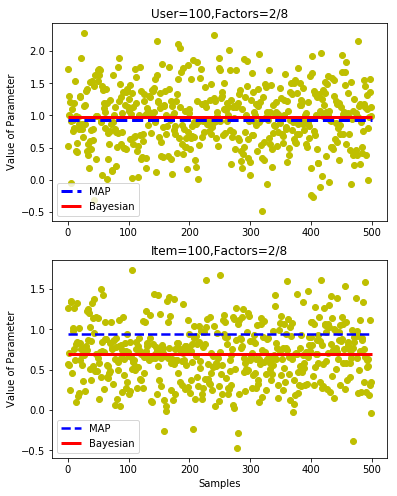

In [47]:
import numpy as np
import matplotlib.pyplot as plt
u = 100 #observe the user=100
i =100 #observe the item=100
mapu = [-1.59723545,0.93588047,-0.8052345,-0.50565011,-0.28202841,0.18825349,-0.32338122,0.12781368]
mapi = [-1.84968092,0.77268257,-1.06162059,-0.67087349,-0.35271768,0.13902233,-0.51233233,0.083131]
exeu = trace['P'][:,u,:]
exei = trace['Q'][:,i,:]
plt.figure(figsize=(6,8))
for i in range(2): 
    if i==0:
        plt.subplot(2,1,i+1)#2行8列
        x = np.arange(0,500)
        y = exeu[:,i+1]
        plt.scatter(x,y,c = 'y',marker = 'o')
        plt.hlines(mapu[i+1], 0, 500, colors = "b", linestyles = "dashed",linewidth=3,label='MAP')
        plt.hlines(np.mean(y), 0, 500, colors = "r", linestyles = "solid",linewidth=3,label='Bayesian')
        #plt.xlabel('Samples')
        plt.ylabel("Value of Parameter")
        plt.title("User=100,Factors=2/8") #图标题
        plt.legend(loc = 'lower left')
    if i==1:
        plt.subplot(2,1,i+1)#2行8列
        x = np.arange(0,500)
        y = exei[:,i]
        plt.scatter(x,y,c = 'y',marker = 'o')
        plt.hlines(mapu[i], 0, 500, colors = "b", linestyles = "dashed",linewidth=2.5,label='MAP')
        plt.hlines(np.mean(y), 0, 500, colors = "r", linestyles = "solid",linewidth=3,label='Bayesian')
        plt.xlabel('Samples')
        plt.ylabel("Value of Parameter")
        plt.title("Item=100,Factors=2/8") #图标题
        plt.legend(loc = 'lower left')

In [1]:
# coding:utf-8  
'''
@author: Jason.F
@data: 2019.08.12
@function: BMF(Bayesian Matrix Factorization) 
           Datatset: MovieLens-1m:https://grouplens.org/datasets/movielens/  
           Evaluation: RMSE
'''
import sys
import time
import logging
import random
import heapq
import math
from collections import defaultdict
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import tensorflow as tf

class DataSet:
    def __init__(self):
        self.trainset, self.testset, self.maxu, self.maxi, self.maxr = self._getDataset_as_list()
        
    def _getDataset_as_list(self):
        #trainset
        filePath = "/data/fjsdata/BMF/ml-1m.train.rating" 
        data = pd.read_csv(filePath, sep='\t', header=None, names=['user', 'item', 'rating'], \
                                 usecols=[0, 1, 2], dtype={0: np.int32, 1: np.int32, 2: np.float})
        maxu, maxi, maxr = data['user'].max()+1, data['item'].max()+1, data['rating'].max()
        print('Dataset Statistics: Interaction = %d, User = %d, Item = %d, Sparsity = %.4f' % \
                  (data.shape[0], maxu, maxi, data.shape[0]/(maxu*maxi)))
        trainset = data.values.tolist()
        #testset
        filePath = "/data/fjsdata/BMF/ml-1m.test.rating" 
        data = pd.read_csv(filePath, sep='\t', header=None, names=['user', 'item', 'rating'], \
                                 usecols=[0, 1, 2], dtype={0: np.int32, 1: np.int32, 2: np.float})
        testset = data.values.tolist()
        return trainset, testset, maxu, maxi, maxr 
    
    def list_to_matrix(self, dataset, maxu, maxi):              
        dataMat = np.zeros([maxu, maxi], dtype=np.float32)
        for u,i,r in dataset:
            dataMat[int(u)][int(i)] = float(r)
        return np.array(dataMat)
    
    def list_to_dict(self, dataset):
        dataDict = {}
        for u,i,r in dataset:
            dataDict[int(u), int(i)] = float(r)
        return dataDict
    
    def getInstances(self, dataset):
        user = []
        item = []
        rate = []
        for u, i, r in dataset:
            user.append(int(u))
            item.append(int(i))
            rate.append(float(r))
        return np.array(user), np.array(item), np.array(rate)
    
class BMF():
    def __init__(self, ds):
        self.maxr = ds.maxr
        self.maxu = ds.maxu
        self.maxi = ds.maxi
        #get the trainset and testset
        train_u, train_i, train_r = ds.getInstances(ds.trainset)
        shuffled_idx = np.random.permutation(np.arange(len(train_u)))
        self.train_u = train_u[shuffled_idx]
        self.train_i = train_i[shuffled_idx]
        self.train_r = train_r[shuffled_idx]
        assert(len(self.train_u) == len(self.train_i) and len(self.train_i) == len(self.train_r)) 
        self.test_u, self.test_i, self.test_r = ds.getInstances(ds.testset)
        assert(len(self.test_u) == len(self.test_i) and len(self.test_i) == len(self.test_r))
    
    def train_BMF(self, K=8):
        meanr = self.maxr/2
        self.x_u = theano.shared(self.train_u)
        self.x_i = theano.shared(self.train_i)
        self.y_r = theano.shared(self.train_r)
        with pm.Model() as self.bmf:#bulid probabilistic model
            # Creating the model
            P = pm.Normal('P', mu=0, sd=meanr, shape=(self.maxu, K))
            Q = pm.Normal('Q', mu=0, sd=meanr, shape=(self.maxi, K))
            tY = pm.Deterministic('tY', pm.math.sum(P[self.x_u,:]*Q[self.x_i,:], axis=1))
            Y = pm.Normal('Y', mu=tY, sd=meanr, observed=self.y_r)#pm.Categorical
            
        with self.bmf: #train the probabilistic model by Bayesian inference
            tstart = time.time()
            print('Start training BMF')
            approx = pm.fit(n=10000, method=pm.ADVI())
            trace = approx.sample(draws=1000)
            elapsed = time.time() - tstart 
            print('Complete BMF training in %d seconds' % int(elapsed))
        return trace
            
    def eval_BMF(self, trace):
        self.x_u.set_value(self.test_u)
        self.x_i.set_value(self.test_i)
        self.y_r.set_value(self.test_r)
        with self.bmf:
            ppc = pm.sample_posterior_predictive(trace, progressbar=True)
            pY = ppc['Y'].mean(axis=0)
            #pY = np.max(ppc['Y'],axis=0)
        assert(pY.shape[0]==self.test_r.shape[0])
        squaredError = []
        for i in range(pY.shape[0]):
            error=self.test_r[i] - pY[i]
            squaredError.append(error * error)
        rmse =math.sqrt(sum(squaredError) / len(squaredError))
        return rmse
    
    def eval_val(self, trace, val_u, val_i, val_r):
        self.x_u.set_value(val_u)
        self.x_i.set_value(val_i)
        self.y_r.set_value(val_r)
        with self.bmf:
            ppc = pm.sample_posterior_predictive(trace, progressbar=True)
            pY = ppc['Y'].mean(axis=0)
            #pY = np.max(ppc['Y'],axis=0)
        assert(pY.shape[0]==val_r.shape[0])
        squaredError = []
        for i in range(pY.shape[0]):
            error=val_r[i] - pY[i]
            squaredError.append(error * error)
        rmse =math.sqrt(sum(squaredError) / len(squaredError))
        return rmse
    
if __name__ == "__main__":
    ds = DataSet()#loading dataset
    bmf = BMF(ds)
    for K in [8, 16, 32, 64]:
        tstart = time.time()
        trace = bmf.train_BMF(K=8)
        rmse = bmf.eval_BMF(trace)
        elapsed = time.time() - tstart 
        print('Complete training in %d seconds' % int(elapsed))
        print("RMSE@{}:{} of testset".format(K, rmse))
        valset = random.sample(ds.trainset, len(ds.testset))#get the same len of testset from trainset as validset.
        val_u, val_i, val_r = ds.getInstances(valset)
        rmse =  bmf.eval_val(trace, val_u, val_i, val_r)
        print("RMSE@{}:{} of valset".format(K, rmse))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Dataset Statistics: Interaction = 994169, User = 6040, Item = 3706, Sparsity = 0.0444
Start training BMF


Average Loss = 2.0634e+06: 100%|██████████| 10000/10000 [49:09<00:00,  3.62it/s]
Finished [100%]: Average Loss = 2.0634e+06
I0812 07:01:39.370591 139940339726080 inference.py:248] Finished [100%]: Average Loss = 2.0634e+06
  1%|          | 9/1000 [00:00<00:11, 88.13it/s]

Complete BMF training in 3035 seconds


  1%|          | 6/1000 [00:00<00:17, 58.42it/s]

Complete training in 3051 seconds
RMSE@8:0.9872640219034287 of testset


100%|██████████| 1000/1000 [00:10<00:00, 95.08it/s]


RMSE@8:0.9276864731249823 of valset
Start training BMF


Average Loss = 2.0636e+06: 100%|██████████| 10000/10000 [46:01<00:00,  3.83it/s]
Finished [100%]: Average Loss = 2.0635e+06
I0812 07:49:23.995435 139940339726080 inference.py:248] Finished [100%]: Average Loss = 2.0635e+06
  1%|          | 10/1000 [00:00<00:10, 92.40it/s]

Complete BMF training in 2840 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

Complete training in 2850 seconds
RMSE@16:0.9880680558769473 of testset


100%|██████████| 1000/1000 [00:09<00:00, 100.43it/s]


RMSE@16:0.9306369398365066 of valset
Start training BMF


Average Loss = 2.0628e+06: 100%|██████████| 10000/10000 [46:06<00:00,  3.60it/s]
Finished [100%]: Average Loss = 2.0628e+06
I0812 08:37:10.054010 139940339726080 inference.py:248] Finished [100%]: Average Loss = 2.0628e+06
  1%|          | 10/1000 [00:00<00:10, 93.53it/s]

Complete BMF training in 2845 seconds


  1%|          | 11/1000 [00:00<00:09, 106.75it/s]

Complete training in 2855 seconds
RMSE@32:0.9873408248959264 of testset


100%|██████████| 1000/1000 [00:10<00:00, 98.51it/s]


RMSE@32:0.9337658796564328 of valset
Start training BMF


Average Loss = 2.0634e+06: 100%|██████████| 10000/10000 [45:43<00:00,  3.70it/s]
Finished [100%]: Average Loss = 2.0633e+06
I0812 09:24:32.462879 139940339726080 inference.py:248] Finished [100%]: Average Loss = 2.0633e+06
  0%|          | 4/1000 [00:00<00:25, 39.79it/s]

Complete BMF training in 2822 seconds


  1%|          | 11/1000 [00:00<00:09, 106.71it/s]

Complete training in 2834 seconds
RMSE@64:0.9861208200729965 of testset


100%|██████████| 1000/1000 [00:10<00:00, 106.49it/s]

RMSE@64:0.9078867505965363 of valset


In [ ]:
# coding:utf-8  
'''
@author: Jason.F
@data: 2019.08.01
@function: BMF(Bayesian Matrix Factorization) 
           Datatset:KnowledgeBase-CC 
           Evaluation: RMSE
'''
import sys
import time
import logging
import random
import heapq
import math
from collections import defaultdict
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import tensorflow as tf

class DataSet:
    def __init__(self):
        self.trainset, self.testset, self.maxu, self.maxi, self.maxr = self._getDataset_as_list()
        
    def _getDataset_as_list(self):
        #trainset
        filePath = "/data/fjsdata/BMF/kbcc_trainset.csv" 
        data = pd.read_csv(filePath, sep='|', low_memory=False, dtype={'csr':int, 'ke':int, 'num':float})
        maxu, maxi, maxr = data['csr'].max()+1, data['ke'].max()+1, data['num'].max()
        print('Dataset Statistics: Interaction = %d, User = %d, Item = %d, Sparsity = %.4f' % \
                  (data.shape[0], maxu, maxi, data.shape[0]/(maxu*maxi)))
        trainset = data.values.tolist()
        #testset
        filePath = "/data/fjsdata/BMF/kbcc_testset.csv" 
        data = pd.read_csv(filePath, sep='|', low_memory=False, dtype={'csr':int, 'ke':int, 'num':float})
        testset = data.values.tolist()
        return trainset, testset, maxu, maxi, maxr  
    
    def list_to_matrix(self, dataset, maxu, maxi):              
        dataMat = np.zeros([maxu, maxi], dtype=np.float32)
        for u,i,r in dataset:
            dataMat[int(u)][int(i)] = float(r)
        return np.array(dataMat)
    
    def list_to_dict(self, dataset):
        dataDict = {}
        for u,i,r in dataset:
            dataDict[int(u), int(i)] = float(r)
        return dataDict
    
    def getInstances(self, dataset):
        user = []
        item = []
        rate = []
        for u, i, r in dataset:
            user.append(int(u))
            item.append(int(i))
            rate.append(float(r))
        return np.array(user), np.array(item), np.array(rate)
    
class BMF():
    def __init__(self, ds):
        self.maxr = ds.maxr
        self.maxu = ds.maxu
        self.maxi = ds.maxi
        #get the trainset and testset
        train_u, train_i, train_r = ds.getInstances(ds.trainset)
        shuffled_idx = np.random.permutation(np.arange(len(train_u)))
        self.train_u = train_u[shuffled_idx]
        self.train_i = train_i[shuffled_idx]
        self.train_r = train_r[shuffled_idx]
        assert(len(self.train_u) == len(self.train_i) and len(self.train_i) == len(self.train_r)) 
        self.test_u, self.test_i, self.test_r = ds.getInstances(ds.testset)
        assert(len(self.test_u) == len(self.test_i) and len(self.test_i) == len(self.test_r))
    
    def train_BMF(self, K=8):
        meanr = self.maxr/2
        self.x_u = theano.shared(self.train_u)
        self.x_i = theano.shared(self.train_i)
        self.y_r = theano.shared(self.train_r)
        with pm.Model() as self.bmf:#bulid probabilistic model
            # Creating the model
            P = pm.Normal('P', mu=0, sd=meanr, shape=(self.maxu, K))
            Q = pm.Normal('Q', mu=0, sd=meanr, shape=(self.maxi, K))
            tY = pm.Deterministic('tY', pm.math.sum(P[self.x_u,:]*Q[self.x_i,:], axis=1))
            Y = pm.Normal('Y', mu=tY, sd=meanr, observed=self.y_r)#pm.Categorical
            
        with self.bmf: #train the probabilistic model by Bayesian inference
            tstart = time.time()
            logging.info('Start training BMF')
            approx = pm.fit(n=10000, method=pm.ADVI())
            trace = approx.sample(draws=500)
            elapsed = time.time() - tstart 
            logging.info('Complete BMF training in %d seconds' % int(elapsed))
        return trace
            
    def eval_BMF(self, trace):
        self.x_u.set_value(self.test_u)
        self.x_i.set_value(self.test_i)
        self.y_r.set_value(self.test_r)
        with self.bmf:
            ppc = pm.sample_posterior_predictive(trace, progressbar=True)
            pY = ppc['Y'].mean(axis=0)
            #pY = np.max(ppc['Y'],axis=0)
        assert(pY.shape[0]==self.test_r.shape[0])
        squaredError = []
        for i in range(pY.shape[0]):
            error=self.test_r[i] - pY[i]
            squaredError.append(error * error)
        rmse =math.sqrt(sum(squaredError) / len(squaredError))
        return rmse
    
if __name__ == "__main__":
    ds = DataSet()#loading dataset
    bmf = BMF(ds)
    for K in [16, 32, 64]:#8, 
        trace = bmf.train_BMF(K)
        rmse = bmf.eval_BMF(trace)
        print("RMSE@{}:{}".format(K, rmse))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Dataset Statistics: Interaction = 2313189, User = 10216, Item = 96324, Sparsity = 0.0024


Average Loss = 7.0679e+06: 100%|██████████| 10000/10000 [4:42:01<00:00,  1.72s/it] 
Finished [100%]: Average Loss = 7.0672e+06
I0811 04:31:27.919111 140404763170560 inference.py:248] Finished [100%]: Average Loss = 7.0672e+06
100%|██████████| 500/500 [00:07<00:00, 68.19it/s]


RMSE@16:1.059928490279239


Average Loss = 8.0517e+06: 100%|██████████| 10000/10000 [9:42:46<00:00,  3.75s/it]  
Finished [100%]: Average Loss = 8.0503e+06
I0811 14:18:39.256559 140404763170560 inference.py:248] Finished [100%]: Average Loss = 8.0503e+06
100%|██████████| 500/500 [00:10<00:00, 56.50it/s]


RMSE@32:1.0789153238668336


Average Loss = 1.47e+07:  26%|██▌       | 2565/10000 [8:44:58<15:00:32,  7.27s/it]   

In [1]:
# coding:utf-8  
'''
@author: Jason.F
@data: 2019.08.01
@function: BMF(Bayesian Matrix Factorization) 
           Datatset: MovieLens-1m:https://grouplens.org/datasets/movielens/  
           Evaluation: RMSE
'''
import sys
import time
import logging
import random
import heapq
import math
from collections import defaultdict
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import tensorflow as tf

class DataSet:
    def __init__(self):
        self.trainset, self.testset, self.maxu, self.maxi, self.maxr = self._getDataset_as_list()
        
    def _getDataset_as_list(self):
        #trainset
        filePath = "/data/fjsdata/BMF/ml-1m.train.rating" 
        data = pd.read_csv(filePath, sep='\t', header=None, names=['user', 'item', 'rating'], \
                                 usecols=[0, 1, 2], dtype={0: np.int32, 1: np.int32, 2: np.float})
        maxu, maxi, maxr = data['user'].max()+1, data['item'].max()+1, data['rating'].max()
        print('Dataset Statistics: Interaction = %d, User = %d, Item = %d, Sparsity = %.4f' % \
                  (data.shape[0], maxu, maxi, data.shape[0]/(maxu*maxi)))
        trainset = data.values.tolist()
        #testset
        filePath = "/data/fjsdata/BMF/ml-1m.test.rating" 
        data = pd.read_csv(filePath, sep='\t', header=None, names=['user', 'item', 'rating'], \
                                 usecols=[0, 1, 2], dtype={0: np.int32, 1: np.int32, 2: np.float})
        testset = data.values.tolist()
        return trainset, testset, maxu, maxi, maxr 
    
    def list_to_matrix(self, dataset, maxu, maxi):              
        dataMat = np.zeros([maxu, maxi], dtype=np.float32)
        for u,i,r in dataset:
            dataMat[int(u)][int(i)] = float(r)
        return np.array(dataMat)
    
    def list_to_dict(self, dataset):
        dataDict = {}
        for u,i,r in dataset:
            dataDict[int(u), int(i)] = float(r)
        return dataDict
    
    def getInstances(self, dataset):
        user = []
        item = []
        rate = []
        for u, i, r in dataset:
            user.append(int(u))
            item.append(int(i))
            rate.append(float(r))
        return np.array(user), np.array(item), np.array(rate)
    
class BMF():
    def __init__(self, ds):
        self.maxr = ds.maxr
        self.maxu = ds.maxu
        self.maxi = ds.maxi
        #get the trainset and testset
        train_u, train_i, train_r = ds.getInstances(ds.trainset)
        shuffled_idx = np.random.permutation(np.arange(len(train_u)))
        self.train_u = train_u[shuffled_idx]
        self.train_i = train_i[shuffled_idx]
        self.train_r = train_r[shuffled_idx]
        assert(len(self.train_u) == len(self.train_i) and len(self.train_i) == len(self.train_r)) 
        self.test_u, self.test_i, self.test_r = ds.getInstances(ds.testset)
        assert(len(self.test_u) == len(self.test_i) and len(self.test_i) == len(self.test_r))
    
    def train_BMF(self, K=8):
        meanr = self.maxr/2
        self.x_u = theano.shared(self.train_u)
        self.x_i = theano.shared(self.train_i)
        self.y_r = theano.shared(self.train_r)
        with pm.Model() as self.bmf:#bulid probabilistic model
            # Creating the model
            P = pm.Normal('P', mu=0, sd=meanr, shape=(self.maxu, K))
            Q = pm.Normal('Q', mu=0, sd=meanr, shape=(self.maxi, K))
            tY = pm.Deterministic('tY', pm.math.sum(P[self.x_u,:]*Q[self.x_i,:], axis=1))
            Y = pm.Normal('Y', mu=tY, sd=meanr, observed=self.y_r)#pm.Categorical
            
        with self.bmf: #train the probabilistic model by Bayesian inference
            tstart = time.time()
            logging.info('Start training BMF')
            approx = pm.fit(n=20000, method=pm.ADVI())
            trace = approx.sample(draws=2000)
            elapsed = time.time() - tstart 
            logging.info('Complete BMF training in %d seconds' % int(elapsed))
        return trace
            
    def eval_BMF(self, trace):
        self.x_u.set_value(self.test_u)
        self.x_i.set_value(self.test_i)
        self.y_r.set_value(self.test_r)
        with self.bmf:
            ppc = pm.sample_posterior_predictive(trace, progressbar=True)
            pY = ppc['Y'].mean(axis=0)
            #pY = np.max(ppc['Y'],axis=0)
        assert(pY.shape[0]==self.test_r.shape[0])
        squaredError = []
        for i in range(pY.shape[0]):
            error=self.test_r[i] - pY[i]
            squaredError.append(error * error)
        rmse =math.sqrt(sum(squaredError) / len(squaredError))
        return rmse
    
if __name__ == "__main__":
    ds = DataSet()#loading dataset
    bmf = BMF(ds)
    for K in [8, 16, 32, 64]:
        trace = bmf.train_BMF(K)
        rmse = bmf.eval_BMF(trace)
        print("RMSE@{}:{}".format(K, rmse))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Dataset Statistics: Interaction = 994169, User = 6040, Item = 3706, Sparsity = 0.0444


Average Loss = 2.0406e+06: 100%|██████████| 20000/20000 [1:56:15<00:00,  2.05it/s]  
Finished [100%]: Average Loss = 2.0406e+06
I0803 02:50:19.709261 140591926970112 inference.py:248] Finished [100%]: Average Loss = 2.0406e+06
100%|██████████| 2000/2000 [00:28<00:00, 71.14it/s] 


RMSE@8:0.9781506102933817


Average Loss = 2.1381e+06: 100%|██████████| 20000/20000 [4:06:23<00:00,  1.34it/s]  
Finished [100%]: Average Loss = 2.138e+06
I0803 07:00:56.613993 140591926970112 inference.py:248] Finished [100%]: Average Loss = 2.138e+06
100%|██████████| 2000/2000 [00:40<00:00, 49.29it/s]


RMSE@16:0.9836086172864684


Average Loss = 2.3273e+06: 100%|██████████| 20000/20000 [6:24:20<00:00,  1.19s/it]  
Finished [100%]: Average Loss = 2.3273e+06
I0803 13:33:25.380676 140591926970112 inference.py:248] Finished [100%]: Average Loss = 2.3273e+06
100%|██████████| 2000/2000 [00:32<00:00, 61.83it/s]


RMSE@32:0.9875828056757613


Average Loss = 2.6703e+06: 100%|██████████| 20000/20000 [12:45:01<00:00,  2.04s/it]  
Finished [100%]: Average Loss = 2.6703e+06
I0804 02:30:04.296186 140591926970112 inference.py:248] Finished [100%]: Average Loss = 2.6703e+06
100%|██████████| 2000/2000 [01:08<00:00, 29.11it/s]


RMSE@64:0.987590154874153
